# Mission field analysis

We start the analisys of the enriched GTR dataset (see `01` and `02` notebooks)

## Mission field analysis

### Descriptive statistics

#### Mission field basics

A mission field represents the combination of keywords (subjects/verbs/objects) that comprise a mission. 

For example, the potential mission field $MF_p$ for `using AI (AI) to prevent, diagnose and treat chronic diseases (C)` is formed by $AI \cup C$. 

This captures the total of technological activity $AI$ that could be devoted to adressing the challenge $C$.

The active mission field $MF_a$ is $AI \cap C$, capturing the actual number of projects that combine the activities.

Some hypotheses:

* $\frac{MF_a}{MF_p} < \frac{A}{Total}$
* $\frac{MF_a}{MF_p} < \frac{C}{Total}$

This means that the challenge is underrepresented among the applications of the technology, and that the technology is underrepresented among the attempted solutions to the challenge.

Note that the above is sort of assuming that the solution field and the challenge field are far apart in the knowledge space. We could test this if we mapped that, but it would require us to classify all projects into their topics. We can sort of proxy this for now by analyzing the organizational network in the three domains. 

The solution seems underrepresented in the challenge compared to the total of projects

The challenge seems underrepresented in the solution compared to the total of projects

#### Trends

We assume growth in the effective mission field but potentially slower than either of its components (there is some sort of barrier preventing the application of the solution to the challenge).

$\frac{\delta MF_a}{\delta t} < \frac{\delta A}{\delta t}$

$\frac{\delta MF_a}{\delta t} < \frac{\delta C}{\delta t}$

#### Funding

The funder for the mission fied might be different from the funder for the constituent parts. I would expect the mission funder to be related (closer) to the challenge.

#### Discipline mix

The effective mission field will contain a higher level of discipline diversity than the constituent parts (although here we need to remember that the constituent parts might also be related to other missions we are not capturing).

## Preamble

In [1]:
%matplotlib inline

from scipy.stats import entropy

import matplotlib.pyplot as plt

## Load data

In [2]:
projects = pd.read_csv('../data/processed/22_1_2019_projects_clean.csv')

### Word embeddings query / Clio query?

To keep things simple, we will train a w2v model, identify synonyms for a set of seed terms and query the data for those

In [3]:
# %load lda_pipeline.py
from gensim import corpora, models
from string import punctuation
from string import digits
import re
import pandas as pd
import numpy as np
from gensim.models import Word2Vec


#Characters to drop
drop_characters = re.sub('-','',punctuation)+digits

#Stopwords
from nltk.corpus import stopwords

stop = stopwords.words('English')

#Stem functions
from nltk.stem import *
stemmer = PorterStemmer()

def flatten_list(a_list):
    return([x for el in a_list for x in el])


def clean_tokenise(string,drop_characters=drop_characters,stopwords=stop):
    '''
    Takes a string and cleans (makes lowercase and removes stopwords)
    
    '''
    

    #Lowercase
    str_low = string.lower()
    
    
    #Remove symbols and numbers
    str_letters = re.sub('[{drop}]'.format(drop=drop_characters),'',str_low)
    
    
    #Remove stopwords
    clean = [x for x in str_letters.split(' ') if (x not in stop) & (x!='')]
    
    return(clean)


class CleanTokenize():
    '''
    This class takes a list of strings and returns a tokenised, clean list of token lists ready
    to be processed with the LdaPipeline
    
    It has a clean method to remove symbols and stopwords
    
    It has a bigram method to detect collocated words
    
    It has a stem method to stem words
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes a corpus (list where each element is a string)
        '''
        
        #Store
        self.corpus = corpus
        
    def clean(self,drop=drop_characters,stopwords=stop):
        '''
        Removes strings and stopwords, 
        
        '''
        
        cleaned = [clean_tokenise(doc,drop_characters=drop,stopwords=stop) for doc in self.corpus]
        
        self.tokenised = cleaned
        return(self)
    
    def stem(self):
        '''
        Optional: stems words
        
        '''
        #Stems each word in each tokenised sentence
        stemmed = [[stemmer.stem(word) for word in sentence] for sentence in self.tokenised]
    
        self.tokenised = stemmed
        return(self)
        
    
    def bigram(self,threshold=10):
        '''
        Optional Create bigrams.
        
        '''
        
        #Colocation detector trained on the data
        phrases = models.Phrases(self.tokenised,threshold=threshold)
        
        bigram = models.phrases.Phraser(phrases)
        
        self.tokenised = bigram[self.tokenised]
        
        return(self)
        
        
        
        

class LdaPipeline():
    '''
    This class processes lists of keywords.
    How does it work?
    -It is initialised with a list where every element is a collection of keywords
    -It has a method to filter keywords removing those that appear less than a set number of times
    
    -It has a method to process the filtered df into an object that gensim can work with
    -It has a method to train the LDA model with the right parameters
    -It has a method to predict the topics in a corpus
    
    '''
    
    def __init__(self,corpus):
        '''
        Takes the list of terms
        '''
        
        #Store the corpus
        self.tokenised = corpus
        
    def filter(self,minimum=5):
        '''
        Removes keywords that appear less than 5 times.
        
        '''
        
        #Load
        tokenised = self.tokenised
        
        #Count tokens
        token_counts = pd.Series([x for el in tokenised for x in el]).value_counts()
        
        #Tokens to keep
        keep = token_counts.index[token_counts>minimum]
        
        #Filter
        tokenised_filtered = [[x for x in el if x in keep] for el in tokenised]
        
        #Store
        self.tokenised = tokenised_filtered
        self.empty_groups = np.sum([len(x)==0 for x in tokenised_filtered])
        
        return(self)
    
    def clean(self):
        '''
        Remove symbols and numbers
        
        '''
        
        
        
    
        
    def process(self):
        '''
        This creates the bag of words we use in the gensim analysis
        
        '''
        #Load the list of keywords
        tokenised = self.tokenised
        
        #Create the dictionary
        dictionary = corpora.Dictionary(tokenised)
        
        #Create the Bag of words. This converts keywords into ids
        corpus = [dictionary.doc2bow(x) for x in tokenised]
        
        self.corpus = corpus
        self.dictionary = dictionary
        return(self)
        
    def tfidf(self):
        '''
        This is optional: We extract the term-frequency inverse document frequency of the words in
        the corpus. The idea is to identify those keywords that are more salient in a document by normalising over
        their frequency in the whole corpus
        
        '''
        #Load the corpus
        corpus = self.corpus
        
        #Fit a TFIDF model on the data
        tfidf = models.TfidfModel(corpus)
        
        #Transform the corpus and save it
        self.corpus = tfidf[corpus]
        
        return(self)
    
    def fit_lda(self,num_topics=20,passes=5,iterations=75,random_state=1803):
        '''
        
        This fits the LDA model taking a set of keyword arguments.
        #Number of passes, iterations and random state for reproducibility. We will have to consider
        reproducibility eventually.
        
        '''
        
        #Load the corpus
        corpus = self.corpus
        
        #Train the LDA model with the parameters we supplied
        lda = models.LdaModel(corpus,id2word=self.dictionary,
                              num_topics=num_topics,passes=passes,iterations=iterations,random_state=random_state)
        
        #Save the outputs
        self.lda_model = lda
        self.lda_topics = lda.show_topics(num_topics=num_topics)
        

        return(self)
    
    def predict_topics(self):
        '''
        This predicts the topic mix for every observation in the corpus
        
        '''
        #Load the attributes we will be working with
        lda = self.lda_model
        corpus = self.corpus
        
        #Now we create a df
        predicted = lda[corpus]
        
        #Convert this into a dataframe
        predicted_df = pd.concat([pd.DataFrame({x[0]:x[1] for x in topics},
                                              index=[num]) for num,topics in enumerate(predicted)]).fillna(0)
        
        self.predicted_df = predicted_df
        
        return(self)
    

/usr/local/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


In [4]:
#Create sentence corpus
sentence_corpus = flatten_list([x.split('. ') for x in projects['abstract']])


#Tokenize etc using the classes above
sentence_tokenised = CleanTokenize(sentence_corpus).clean().bigram()

#Also tokenise by documents so we can query them later
corpus_tokenised = CleanTokenize(projects['abstract']).clean().bigram()


In [5]:
#Training W2V
w2v = Word2Vec(sentence_tokenised.tokenised)

In [6]:
with open(f'../models/{today_str}_word_embeddings.p','wb') as outfile:
    pickle.dump(w2v,outfile)

In [7]:
def similarity_chaser(seed_list,model,similarity,occurrences=1):
    '''
    Takes a seed term and expands it with synonyms (above a certain similarity threshold)
    
    '''
    
    #All synonyms of the terms in the seed_list above a certain threshold
    set_ws = flatten_list([[term[0] for term in model.most_similar(seed) if term[1]>similarity] for seed in seed_list])
    
    #return(set_ws)
    
    #This is the list of unique occurrences (what we want to return at the end)
    set_ws_list = list(set(set_ws))
    
    #For each term, if it appears multiple times, we expand
    for w in set_ws:
        if set_ws.count(w)>occurrences:
            
            #As before
            extra_words = [term[0] for term in model.wv.most_similar(w) if term[1]>similarity]
            
            set_ws_list + extra_words
            
    #return(list(set(set_ws_list)))
    #return(set_ws_list)
    return(set_ws)

    
def querier(corpus,keywords):
    '''
    Loops over a tokenised corpus and returns varios measures indicating the presence of keywords in it.
    
    This includes:
    
    * Whether at least one keyword appears
    * How many keywords appear
    * What keywords appear
    
    
    '''
    #Empty dict with keywords
    #kw_dict = {k:[] for k in keywords}
    
    #Loop through the corpus and create a vectorised df of the keywords
    
    out = pd.concat([pd.Series({x:(doc.count(x)) for x in keywords}) for doc in corpus],axis=1).T
    
    
    #print(kw_dict)
    #Note that this also returns a sum of the keywords over the rows and a 
    return([out, out.sum(axis=1)])
    

#     #Intersection of tokens
#     if intersect==True:
    
#         out = [len(set(keywords) & set(document)) for document in corpus]
    
#     else:
#     #Otherwise it counts the total of tokens present in an abstract
        
#         out = [np.sum([x.count(k) for k in keywords]) for x in corpus]
    
    
    
    
    return(out)
    
    

### AI and Chronic diseases (crude keyword search-based)

In [8]:
#These are prototype words. 
ai_seed = ['machine_learning','artificial_intelligence','deep_learning','ai','machine_vision','text_mining','data_mining']
chronic_seed = ['chronic_disease','chronic_condition','addiction','alzheimers','atrial_fibrillation','autoimmune_disease',
               'lupus','bipolar_disorder','blindness','cerebral_palsy','chronic_hepatitis','depression','chronic_pain',
               'deafness','blindness','endometriosis','epilepsy','hiv','aids','huntingtons','hypertension','lyme',
               'sclerosis','parkinsons','sickle_cell']

#Discipline terms
discs = ['biological_sciences', 'physics', 'engineering_technology',
       'medical_sciences', 'social_sciences', 'mathematics_computing',
       'environmental_sciences', 'arts_humanities']

#Impact terms
imps = ['prods', 'ip', 'tech', 'spin', 'pubs']



In [9]:
def random_check(corpus,num,length):
    '''
    Prints num random examples form corpus
    
    '''
    
    selected = np.random.randint(0,len(corpus),num)
    
    texts  = [text for num,text in enumerate(corpus) if num in selected]
    
    for t in texts:
        print(t[:length])
        print('====')

In [10]:
class missionKeywords():
    '''
    
    input: a list of projects with descriptions, dates, funding and outputs.
    
    -Expands keywords in a model (this could be clio or something else
    '''
    
    def __init__(self,projects,corpus_tokenised,model):
        '''
        
        Initialises the class with the projects and the w2v model we will use.
        
        '''
        
        self.projects = projects

        #This is the project df but with text description tokenised. We query it with the keywords 
        
        self.tokenised = corpus_tokenised
        self.w2v = model
        
        
    def keyword_expansion(self,mission_dict,thres):
        '''
        
        Expands a seed list of keywords. We input those as a dict where key corresponds to the type of input (solution or
        challenge, say) and the values are a list with the name of the entity (eg 'AI') and the seedlist to expand
        
        '''
        
        #Store the names eg 'challenge_chronic'
        self.names = [v[0] for k,v in mission_dict.items()]
        
        #Store the keywords
        self.keywords = [v[1] for k,v in mission_dict.items()]
        
        #Expand the keywords
        self.expanded_keywords = [list(set(kw + similarity_chaser(seed_list=kw,model=self.w2v,similarity=thres))) for
                                 kw in self.keywords]
        
        return(self)
        
    

In [11]:
class missionClassifier(missionKeywords):
    '''
    Classifies projects based on their keywords
    
    '''
    
    def __init__(self,missionKeywords):
        '''
        Initialise
        
        '''
        
        self.projects_labelled = missionKeywords.projects.copy()
        self.tokenised = missionKeywords.tokenised
        self.names = missionKeywords.names
        self.expanded_keywords = missionKeywords.expanded_keywords
    
    
    def filter_keywords(self,kws_to_drop):
        '''
        We can use it to drop irrelevant keywords. We 
        
        '''
                      
        #self.projects_labelled = self.projects_labelled[[x for x in self.projects_labelled.columns if x not in kws_to_drop]]
        
        self.expanded_keywords = [[x for x in kwset if x not in kws_to_drop] for kwset in self.expanded_keywords]
        
        
        return(self)
   
    
        
    
    def query_data(self,verbose=True):
        '''
        Queries the data with the keywords. It stores two attributes: the kw counts contain the counts by keywords 
        and challenge name; it also stores the projects labelled with an extra variable that
        counts the number of times that keywords in either set of keywords appears in the data.
        
        '''
        
        self.kw_counts = {}
        
        projects_labelled = self.projects_labelled
        tokenised = self.tokenised
        
        #We look for projects with keywords. Loop over name and extract the right index from the expanded keyword set.
        #This could also work as a dict.
        
        for num,name in enumerate(self.names):
            
            if verbose==True:
                print(name)
            
            outputs = querier(tokenised,self.expanded_keywords[num])
            
            self.kw_counts[name] = outputs[0]
            
            projects_labelled[name] = outputs[1]
            
        self.projects_labelled = projects_labelled
        
        return(self)
        
        
        
    

In [12]:
class missionProfiler(missionClassifier):
    '''
    Takes as input an instance of the class missionClassifier

    -Generates some descriptive statistics about the projects
    -Generates some graphs about the projects.
    
    '''
    
    def __init__(self,missionClassifier):
        '''
        
        Initialise
        '''
        
        self.projects_labelled = missionClassifier.projects_labelled.copy()
        self.names = missionClassifier.names.copy()
        self.expanded_keywords = missionClassifier.expanded_keywords.copy()
        
        self.column_names = [self.names[0]+'_and_'+self.names[1],self.names[0],self.names[1]]
    
    
    def mission_examples(self,n,length,text_var='abstract',thr=0):
        '''
        Prints n examples of missions using the text variable that was specified
        
        '''
        
        names = self.names
        
        for name in names:
            print(name)
            print('\n')
            
            random_check(corpus=list(self.projects_labelled.loc[self.projects_labelled[name]>thr,text_var]),
                         num=n,
                         length=200)
            
            print('\n')
        
        print(names[0]+' and ' + names[1])
        print('\n')
        random_check(corpus=list(self.projects_labelled.loc[
            (self.projects_labelled[names[0]]>thr) & (self.projects_labelled[names[1]]>thr),text_var]),
                         num=n,
                         length=200)
            
        
        
    def mission_field_basics(self,field_filter=[0,0],verbose=True):
        '''
        Generates estimates of activity in a field. field_filter refers to whether
        '''
        
        projects = self.projects_labelled
        names = self.names
        
        #Do the filter. Note that we assume that the user here will have done some EDA of the results to choose the right
        #filter.
        
        #Binarise. Note that the default assumes that the values here are a 
        for num,n in enumerate(names):
            projects[n] = projects[n].apply(lambda x: 1 if x> field_filter[num] else 0)
            
        
        
        #What's the size of the potential and effective mission field?
        #TODO: generalise to more than two fields.
        
        #Potential mission field
        union = projects.loc[(projects[names[0]]==True)|(projects[names[1]]==True),:]

        #Active mission field
        intersection = projects.loc[(projects[names[0]]==True)& (projects[names[1]]==True),:]

        #field 0 totals
        field_0 = projects.loc[(projects[names[0]]==True),:]

        #Fields 1 totals
        field_1 = projects.loc[(projects[names[1]]==True),:]
        
        #We are not very interested in the union of fields
        self.sets = [intersection,field_0,field_1]

        summary = {names[0]+'_or_'+names[1]:len(union),
                   names[0]+'_and_'+names[1]:len(intersection),
                   names[0]+'_total':len(field_0),
                   names[1]+'_total':len(field_1)}
        
        if verbose==True:
            print(summary)
        
        #Store the mission summary
        self.mission_summary = summary
        
               
        #Mission basics (over / underrepresentation of )
        mission_basics = pd.Series([100*len(intersection)/len(field_0),100*len(field_1)/len(projects),
                                    100*len(intersection)/len(field_1),100*len(field_0)/len(projects)],
               index=[names[0]+'_and_'+names[1]+'as_share_of_'+names[0],
                      names[1]+'_as_share_of all',
                      names[0]+'_and_'+names[1]+'_as_share_of'+names[1],
                      names[0]+'_as_share_of all'])
        
        self.mission_basics = mission_basics
        
        return(self)
        
    def mission_trends(self,years=[2006,2019],funding=False,year_var='year'):
        '''
        Calculates mission trends over time.
        
        '''
        
        #Extract projects
        projects =self.projects_labelled
        
        names = self.names
        
        #Results dict
        
        self.trends = {}
        
        
        #####
        #Year trends
        #####
        
        #Year counts for each variable of interest
        trends = pd.concat([df[year_var].value_counts(normalize=1) for df in self.sets],axis=1)
        
        trends.columns =self.column_names
        
        project_trends = trends.loc[(trends.index>years[0]) & (trends.index<years[1])]
        
        self.trends['project_trends'] = project_trends
        
        
        #And also look at funding (if available)
        if funding!=False:
            
            #This calculates totals of funding and normalises over the interval to see if recent periods have more activity
            
            funding_trends = pd.concat([df.groupby(year_var)[funding].sum() for df in self.sets],axis=1)
            
            funding_trends.columns = self.column_names
            
            funding_norm = funding_trends.apply(lambda x: x/x.sum(),axis=0)
            
            funding_norm = funding_norm.loc[(funding_norm.index>years[0]) & (funding_norm.index<years[1])]

            self.trends['funding_trends'] = funding_norm
    
        
        ####
        #Yearly shares
        ####
        
        #Normalises for each period. NB there is a loooot of repetition below. Need to refactor.
        
        trends_as_share = pd.concat([df.year.value_counts() for df in self.sets],axis=1)

        trends_as_share.columns = self.column_names

        #This gets the number of projects in the mission as a share of the total
        trends_as_share[
            f'mission_field_share_{names[0]}'],trends_as_share[f'mission_field_share_{names[1]}'] = [
            trends_as_share.iloc[:,0]/trends_as_share.iloc[:,num] for num in [1,2]]
        
        trends_as_share = trends_as_share.loc[(trends_as_share.index>years[0]) & (trends_as_share.index<years[1])]
        
        self.trends['project_shares'] = trends_as_share
        
        #And also funding (if available)
        
        if funding != False:
            
            #We use the funding trend df from above
            funding_as_share = funding_trends.copy()
            
            funding_as_share[
                f'mission_field_share_{names[0]}'],funding_as_share[f'mission_field_share_{names[1]}'] = [
                funding_as_share.iloc[:,0]/funding_as_share.iloc[:,num] for num in [1,2]]
            
            funding_as_share = funding_as_share.loc[(funding_as_share.index>years[0]) & (funding_as_share.index<years[1])]
            
            self.trends['funding_shares'] = funding_as_share
            
        return(self)
            
            
    def funder_trends(self,years=[2006,2019],funder_var='funder',year_var='year',funding=False):
        '''
        Funding plots
        
        '''
        
        
        self.funders = {}
        
        names = self.names
        
        #####
        #Funding totals
        ####
        
        #As before... this gets funder shares of activity
        funders = pd.concat([df[funder_var].value_counts(normalize=1) for df in self.sets],axis=1)

        funders.columns = self.column_names
        
        self.funders['funder_projects'] = funders
        
        #If we want to look at funding
        
        if funding != False:
            funding_shares = pd.concat([df.groupby(funder_var)[funding].sum() for df in self.sets],axis=1)
            
            funding_shares = funding_shares.apply(lambda x: x/x.sum(),axis=0)
            
            funding_shares.columns = self.column_names
        
            self.funders['funder_funding'] = funding_shares

        ######
        #Funding trends
        ######
        
        mission_field = self.sets[0]
        
        self.funders['funder_project_trends'] = pd.crosstab(mission_field[year_var],mission_field[funder_var])
        
        if funding != False:
            
            funder_funding_trends = mission_field.groupby([year_var,funder_var])[funding].sum()
            
            
            
            self.funders['funder_funding_trends'] = pd.pivot_table(
                funder_funding_trends.reset_index(drop=False),index=year_var,columns=funder_var,values=funding).fillna(0)
            
        return(self)
            
            
    def discipline_mix(self,disc_vars = discs,thres=0.1):
        '''
        Estimates rough measures of interdisciplinarity for projects
        '''
        
        #Calculates the entropy for each project and stores it in the sets
        self.sets[0]['entropy'],self.sets[1]['entropy'],self.sets[2]['entropy'], = [
            df[disc_vars].apply(entropy,axis=1) for df in self.sets]
        
        
        disc_distr = pd.concat([df[disc_vars].applymap(lambda x: x>thres).sum(axis=1).value_counts(normalize=True) 
                                  for df in self.sets],axis=1).fillna(0)


        disc_distr.columns = self.column_names
        
        
        self.discipline_mix = disc_distr
        
        return(self)
        
        

    def impact_mix(self,years=[2006,2019],year_var='year',impact_vars=imps):
        
        '''
        Compares impact stats in different fields.
        '''
        
        
        imps_share = pd.concat([df.loc[
            (df[year_var]>years[0]) & (df[year_var]<years[1]),impact_vars].mean() for df in self.sets],axis=1)
        
        imps_share.columns = self.column_names

        imps_norm = imps_share.T/imps_share.T.mean()
        
        self.impacts = [imps_share,imps_norm]
        
        return(self)
    
        
        
        
           

#### Classify projects into categories using the expanded keyword search

In [13]:
#Initialise the mission keyword expander and expand
mk = missionKeywords(projects,corpus_tokenised.tokenised,w2v)

mission_dict = {'solution':['ai',ai_seed],'challenge':['chronic_condition',chronic_seed]}

mk.keyword_expansion(mission_dict,thres=0.8)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [14]:
#Initialise the mission classifier and extract the data
mc = missionClassifier(mk)

mc.query_data()

ai
chronic_condition


#### Intermediate analysis: Plot keyword frequencies

In [15]:
import seaborn as sns

In [16]:
mission_keywords = pd.concat([mc.kw_counts[x] for x in mc.names],axis=1)

#How many mission keywords are there?

print(mc.kw_counts['ai'].shape[1], mc.kw_counts['chronic_condition'].shape[1])

23 170


22 keywords related to machine learning and 171 related to chronic diseases

What are the top 50 chronic keywords? Let's focus on them below

In [17]:
high_chronic_kws = list(mc.kw_counts['chronic_condition'].sum().sort_values(ascending=False)[:50].index)

In [18]:
def remove_diagonal(df):
    '''
    Removes the diagonal in a square df. Otherwise the colourscale is drowned by the corr=1 
    
    '''
    
    for c in df.columns:
        for r in df.index:
            if c==r:
                df.loc[r,c]=0
                
    return(df)

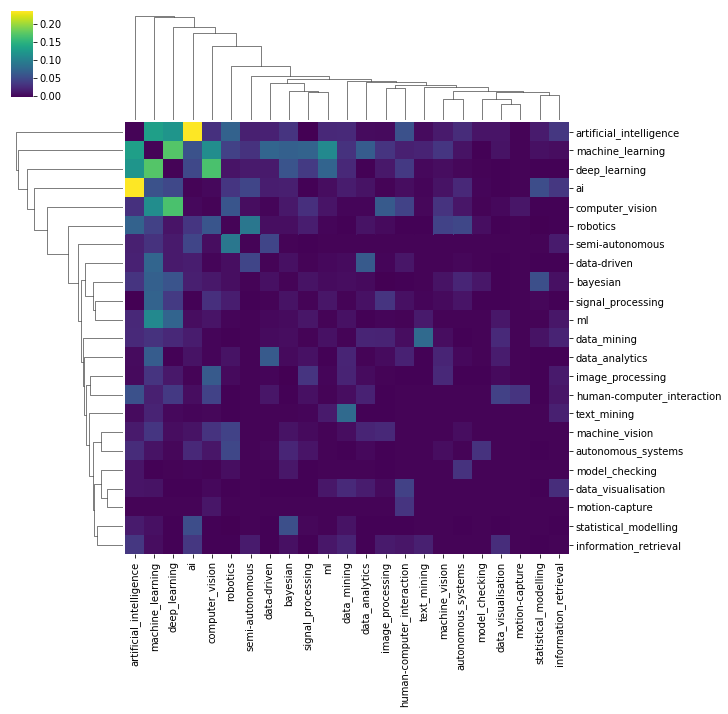

In [19]:
#Can we look for clusters

sns.clustermap(remove_diagonal(mission_keywords[mc.expanded_keywords[0]].corr()),cmap='viridis')

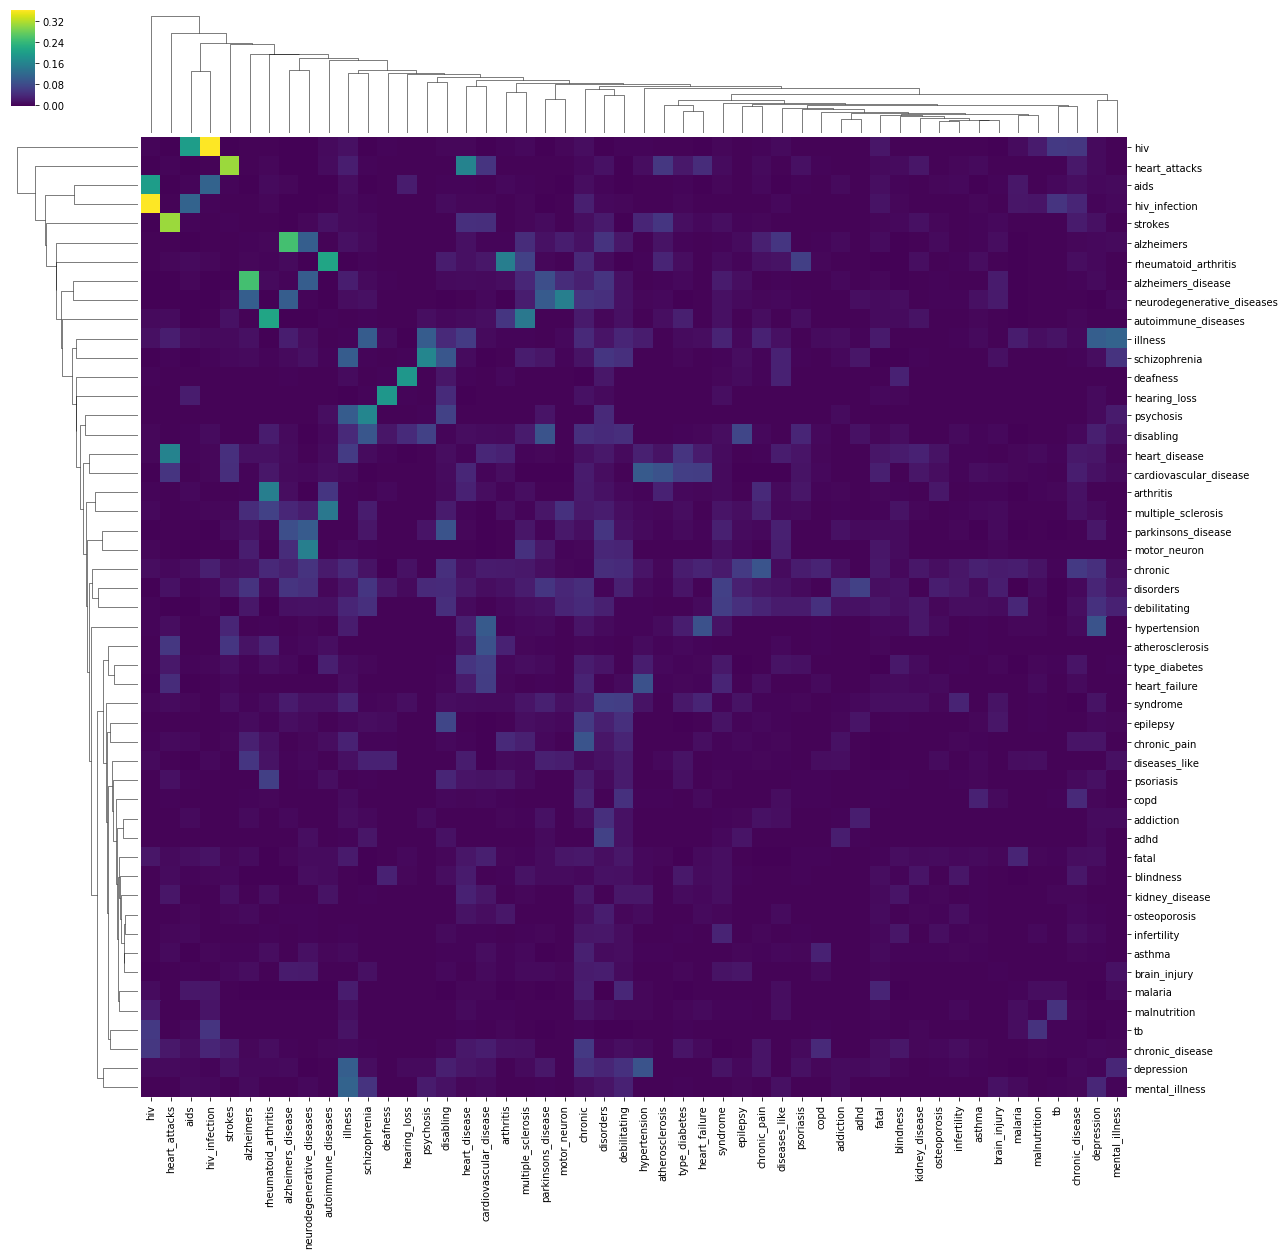

In [20]:
#Can we look for clusters

sns.clustermap(remove_diagonal(mission_keywords[high_chronic_kws].corr()),cmap='viridis',figsize=(20,20))

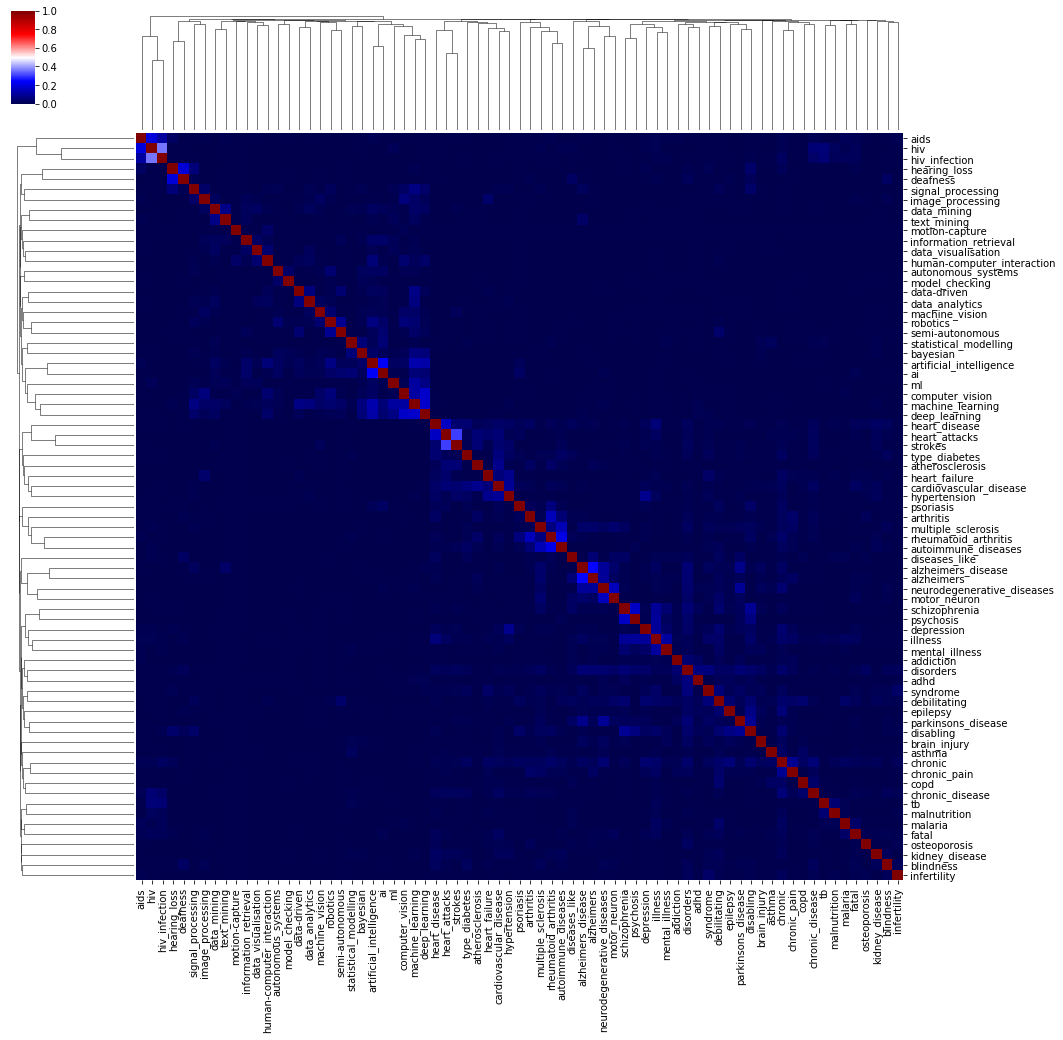

In [21]:
ai_to_chronic_corr = mission_keywords[mc.expanded_keywords[0]+high_chronic_kws].corr()

sns.clustermap(ai_to_chronic_corr,cmap='seismic',figsize=(16,16))

Unsurprisingly, the clusters are inside disciplines rather than across them.

Let's visualise topic co-occurrence as a network.


### Network analysis of keywords co-occurrence

In [22]:
from itertools import combinations
import networkx as nx

In [23]:
def make_network_from_doc_term_matrix(dt_matrix,weight_filter=False):    
    '''
    Takes a document-term matrix and returns a network.
    Offers the option to filter the network based on its weights (the parameter is a quantile if !=False)
    
    '''
    
    
    #Melt the data so we have a project-kw df
    long_topics = pd.melt(dt_matrix.reset_index(drop=False),id_vars='index')

    #Remove terms not happening in a project (Note that this throws away instances where a term occurs multiple times in a doc)
    topics_grouped = long_topics.loc[long_topics.value>0,:].groupby('index')['variable'].apply(lambda x: list(x))
    
    #And now we want to tun this into an edge list
    #This extracts pairs of combinations from topics in a project, sorts them and counts how many there are.

    edge_list = pd.Series('&&'.join(pair) for pair in flatten_list(
        [sorted(combinations(x,2),key=lambda x: x[0],reverse=False) for x in topics_grouped])).value_counts()
    
    
    #This creates the edge list in a format that can be read by nx
    edge_list = pd.concat([pd.Series({'source':v.split('&&')[0],
                                      'target':v.split('&&')[1], 'weight':l}) for v,l in zip(edge_list.index,edge_list)],axis=1).T
    
    
    #Create the network
    net = nx.from_pandas_edgelist(edge_list,edge_attr='weight')

    if weight_filter!=False:
        
        #Filter edges to focus on larger connections

        #Find the top quantile
        quant = pd.Series(list(dict(net.degree).values())).quantile(q=weight_filter)

        sub_g = [(u,w) for u,w,attr in net.edges.data(data=True) if attr['weight']>quant]

        net = net.edge_subgraph(sub_g)
        
    
    return(net)

In [24]:
net = make_network_from_doc_term_matrix(dt_matrix=mission_keywords,weight_filter=0.3)

In [25]:
#Label categories
for n in net.node:
    
    if (n in mc.expanded_keywords[0]) & (n in mc.expanded_keywords[1]):
        net.node[n]['category'] = 'both'
    elif n in mc.expanded_keywords[0]:
        net.node[n]['category'] = 'ai'
    else:
        net.node[n]['category'] = 'chronic'

In [26]:
from webweb import Web

# create the web
web = Web(nx_G=subnet)

# scale edge widths by weight so we can see a visual difference
web.display.scaleLinkWidth = True

# show the visualization
#web.show()
#web.save('../reports/figures/web_web.pdf')

NameError: name 'subnet' is not defined

## Mission field analysis

#### Run the mission profiler

In [ ]:
#Initialise the mission classifier and extract the data
mc = missionClassifier(mk)

#Post exploration we remove some very generic terms
kws_to_drop = ['fatal','illness','camels','syndrome']
mc.filter_keywords(kws_to_drop)

mc.query_data()

In [ ]:
#Initialise the mission profiler

mprof = missionProfiler(mc)

In [ ]:
mprof.mission_field_basics().mission_trends(funding='amount').funder_trends(funding='amount').discipline_mix().impact_mix()

In [ ]:
mprof.mission_basics.plot.bar(color=['orange','blue','orange','blue'])

#### Trends

In [ ]:
fig, ax = plt.subplots(nrows=2,figsize=(12,8),ncols=2,sharex='row')

mprof.trends['project_trends'].rolling(window=4).mean().plot(ax=ax[0][0])
mprof.trends['funding_trends'].rolling(window=4).mean().plot(ax=ax[1][0])

mprof.trends['project_shares'].iloc[:,-2:].rolling(window=4).mean().plot(ax=ax[0][1])
mprof.trends['funding_shares'].iloc[:,-2:].rolling(window=4).mean().plot(ax=ax[1][1])

#### Funding

The funder for the mission fied might be different from the funder for the constituent parts. I would expect the mission funder to be related (closer) to the challenge.

In [ ]:
fig, ax = plt.subplots(figsize=(4,8),nrows=2)

mprof.funders['funder_projects'].T.plot.bar(stacked=True,ax=ax[0],width=0.8)
mprof.funders['funder_funding'].T.plot.bar(stacked=True,ax=ax[1],width=0.8)

ax[0].legend(bbox_to_anchor=(1,1))
ax[1].legend().set_visible(False)

#### Discipline mix

The effective mission field will contain a higher level of discipline diversity than the constituent parts (although here we need to remember that the constituent parts might also be related to other missions we are not capturing).

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))

_ = [ax.hist(df['entropy'],bins=20,color=col,alpha=0.6,density=True) for df,col in zip(mprof.sets,['blue','orange','green'])]

In [ ]:
(100*mprof.discipline_mix.T).plot.bar()

### Impacts

In [ ]:
mprof.impacts[1].plot.bar()

In [ ]:
#Here we focus on the more recent period (taking into account that the AI / chronic projects tend to be more recent)
mprof.impact_mix(years=[2014,2018]).impacts[1].plot.bar()

### Network analysis

Now we want to visualise the organisational network of the mission field: what organisations are connected with each other in this network?

Who are the key players in each of the three 'fields' (chronic, AI and AI-chronic), in total number of projects and relative specialisation?







In [ ]:
links = pd.read_csv('../data/external/gtr/2019-01-24/gtr_link_table.csv')
orgs = pd.read_csv('../data/external/gtr/2019-01-24/gtr_organisations.csv')

The logic below is:

``merge projects and links on project ids, and merge that with organisations on entity ids``


In [ ]:
#We want to avoid cofunding organisations, fellow organisations etc

my_vars = ['COLLAB_ORG','LEAD_ORG','PARTICIPANT_ORG']

In [ ]:
project_orgs = pd.merge(
    pd.merge(mprof.projects_labelled,links.loc[links.table_name=='gtr_organisations'],left_on='index',right_on='project_id'),
    orgs[['id','name']],left_on='id',right_on='id')

projects_orgs = project_orgs.loc[[x in my_vars for x in project_orgs['rel']],:]

In [ ]:
project_orgs['ai_and_chronic_condition'] = [(x>0) & (y>0) for x,y in zip(project_orgs['ai'],project_orgs['chronic_condition'])]

In [ ]:
total_org_freqs = project_orgs['name'].value_counts(normalize=1)

var_names = ['ai','chronic_condition','ai_and_chronic_condition']

mission_org_freqs = pd.concat([
    project_orgs.loc[project_orgs[var]>0,'name'].value_counts(normalize=1) for var in var_names],axis=1).fillna(0)

mission_org_freqs.columns=var_names

fig,ax = plt.subplots(figsize=(5,10))

mission_org_freqs.loc[total_org_freqs.index[:50]][::-1].plot.barh(ax=ax,title=
                                                                  'Share of activity in relevant areas for top research organisations in the UK')

Note that the EPSRC and the MRC are still there (?)

In [ ]:
# Now do it with some normalisation

mission_org_freqs_norm = pd.concat([
    project_orgs.loc[project_orgs[var]>0,'name'].value_counts(normalize=1)/total_org_freqs for var in var_names],axis=1).fillna(0)

mission_org_freqs_norm.columns=var_names

fig,ax = plt.subplots(figsize=(5,12))

mission_org_freqs_norm.loc[total_org_freqs.index[:200]].sort_values('ai_and_chronic_condition',ascending=True)[-50:].plot.barh(
    ax=ax,title='Organisations with high specialisation in the mission field')

In [ ]:
mission_org_freqs_norm.corr()

Interesting - it looks like organisations that are strong in AI tend to apply it in other areas rather than the other way around.

#### Conclude with a network visualisation

In [ ]:
def make_network_from_element_lists(element_list,index='index',variable='variable',weight_filter=False):    
    '''
    Takes a list where every element is a list of elements
    Offers the option to filter the network based on its weights (the parameter is a quantile if !=False)
    
    '''
    
    
    #Remove terms not happening in a project (Note that this throws away instances where a term occurs multiple times in a doc)
    topics_grouped = element_list.groupby(index)[variable].apply(lambda x: list(x))
    
    #And now we want to tun this into an edge list
    #This extracts pairs of combinations from topics in a project, sorts them and counts how many there are.

    edge_list = pd.Series('&&'.join(pair) for pair in flatten_list(
        [sorted(combinations(x,2),key=lambda x: x[0],reverse=False) for x in topics_grouped])).value_counts()
    
    
    e1,e2 = [[x.split('&&')[num] for x in edge_list.index] for num in [0,1]]

    edge_df= pd.DataFrame({'source':e1,'target':e2,'weight':edge_list}).reset_index(drop=True)
    
    
    #Create the network
    net = nx.from_pandas_edgelist(edge_df,edge_attr='weight')

    if weight_filter!=False:
        
        #Filter edges to focus on larger connections

        #Find the top quantile
        quant = pd.Series(list(dict(net.degree).values())).quantile(q=weight_filter)

        sub_g = [(u,w) for u,w,attr in net.edges.data(data=True) if attr['weight']>quant]

        net = net.edge_subgraph(sub_g)
        
    
    return(net)

In [ ]:
mission_orgs = project_orgs.loc[[(x>0) | (y>0) | (z>0) for x,y,z in zip(project_orgs['ai'],
                                                                           project_orgs['chronic_condition'],
                                                                           project_orgs['ai_and_chronic_condition'])]]

org_sets = [set(project_orgs.loc[project_orgs[var]>0,'name']) for var in var_names]

In [ ]:
# mission_nets = [make_network_from_element_lists(
#     project_orgs.loc[project_orgs[var]>0],index='project_id',
#      variable='name',weight_filter=0.5) for var in var_names]
# # create the web
# web = Web(display={'nodes':{num:{'name':name} for num,name in enumerate(set(mission_orgs['name']))}})
# web.networks.ai(nx_G=mission_nets[0])
# web.networks.chronic_cond(nx_G=mission_nets[1])
# web.networks.ai_and_chronic_cond(nx_G=mission_nets[2])
# # scale edge widths by weight so we can see a visual difference
# web.display.scaleLinkWidth = True

# # show the visualization
# web.show()
# #web.save('../reports/figures/web_web.pdf')

In [ ]:
mission_net = make_network_from_element_lists(mission_orgs,index='project_id',variable='name',weight_filter=0.3)

In [ ]:
#Label categories
for n in mission_net.node:
    
    if n in org_sets[2]:
        mission_net.node[n]['category']='mission_field'
        
    elif n in org_sets[0]:
        mission_net.node[n]['category']='ai_field'
    
    elif n in org_sets[1]:
        mission_net.node[n]['category']='chronic_field'

In [ ]:
# create the web
web = Web(nx_G=mission_net)

# scale edge widths by weight so we can see a visual difference
web.display.scaleLinkWidth = True

web.show()

### [Done]


* Produce a better query system: a better seed list would help.
* Package the descriptive stat generator into a function or class. This should be generic enough to accept dfs from other sources (eg H2020 and OpenAIRE).
* Reimplement and test the above. Check how many of the new projects were already captured by the two broader categories


### Next steps
* Organisation visualisation
* Other indicators
* Apply functions to other data and / or challenge.

### Other combinations
* Integrate with TRL analysis
* Integrate with SDG analysis
* Check social media discussion around papers


### Ageing and inclusion/inequality (crude keyword search-based)

In [ ]:
age_expanded = synonym_chaser(seed_list=['ageing','aging'],model=w2v,similarity=0.8)
inclusion_expanded = synonym_chaser(seed_list=['inclusion','inclusiveness','inclusive','inequality'],model=w2v,similarity=0.8)

In [ ]:
projects['has_age'],projects['has_inclusion'] = [querier(corpus_tokenised.tokenised,keys) for keys in [age_expanded,inclusion_expanded]]

In [ ]:
pd.crosstab(projects['has_age']>0,projects['has_inclusion']>0)

In [ ]:
projects.loc[(projects['has_age']>0) & (projects['has_inclusion']>0)].head()

In [ ]:
1100*2/3